In [1]:
from qaravan.core import * 
from qaravan.tensorQ import *
from plotting import *

In [2]:
gate_list = [H(0), CNOT([1,0], 3), CNOT([2,1], 3)]
circ = Circuit(gate_list, 3)
mps = MPSSim(circ)
final_mps = mps.run()
 
# compare to 3 qubit GHZ statevector 
sv = final_mps.to_vector()
sv2 = np.zeros(8, dtype=complex)
sv2[0] = 1/np.sqrt(2)
sv2[7] = 1/np.sqrt(2)
# now compare the two
np.allclose(sv, sv2) # should be True

100%|██████████| 3/3 [00:00<00:00, 3180.72it/s]


True

In [3]:
# let's test for a random circuit
skeleton = brickwall_skeleton(6, depth=3)
circ = two_local_circ(skeleton)

exact_sim = StatevectorSim(circ)
exact_sim.run()
sv = exact_sim.get_statevector()

mps_sim = MPSSim(circ)
mps = mps_sim.run()
approx_sv = mps.to_vector()

np.allclose(sv, approx_sv, atol=1e-2)  # should be True

100%|██████████| 6/6 [00:00<00:00, 1038.97it/s]


True

In [4]:
# let's manually check how center of MPS changes with gate actions 
init_state = random_mps(6)
init_state.normalize()
sim = MPSSim(circ, init_state=init_state)
sim.initialize_state()

for gate in circ:
    sim.apply_gate(gate)
    check_center(sim.state)

MPS Orthogonality Structure:
----------------------------------------
Site 0: L (left-orthonormal)
Site 1: C (center, mixed)
Site 2: R (right-orthonormal)
Site 3: R (right-orthonormal)
Site 4: R (right-orthonormal)
Site 5: R (right-orthonormal)
Norm: 1.000000-0.000000j
MPS Orthogonality Structure:
----------------------------------------
Site 0: L (left-orthonormal)
Site 1: L (left-orthonormal)
Site 2: L (left-orthonormal)
Site 3: C (center, mixed)
Site 4: R (right-orthonormal)
Site 5: R (right-orthonormal)
Norm: 1.000000-0.000000j
MPS Orthogonality Structure:
----------------------------------------
Site 0: L (left-orthonormal)
Site 1: L (left-orthonormal)
Site 2: L (left-orthonormal)
Site 3: L (left-orthonormal)
Site 4: L (left-orthonormal)
Site 5: L (left-orthonormal)
Norm: 1.000000-0.000000j
MPS Orthogonality Structure:
----------------------------------------
Site 0: L (left-orthonormal)
Site 1: L (left-orthonormal)
Site 2: C (center, mixed)
Site 3: R (right-orthonormal)
Site 4: R

In [5]:
# applying next-nearest neighbor gates

skeleton = ss_triad_skeleton(6, depth=1)
circ = rxx_layer(skeleton)
print(circ)

exact_sim = StatevectorSim(circ)
exact_sim.run()
sv = exact_sim.get_statevector()

mps_sim = MPSSim(circ)
mps = mps_sim.run()
approx_sv = mps.to_vector()
np.allclose(sv, approx_sv, atol=1e-2)  # should be True

RXX gate on site(s) (0, 2) with angle(s) (0.11570512010275008,) 
RXX gate on site(s) (3, 5) with angle(s) (1.3848428153865922,) 
RXX gate on site(s) (2, 3) with angle(s) (0.282837179402067,)


100%|██████████| 2/2 [00:00<00:00, 897.75it/s]


True

In [6]:
# test if trivial compression is working correctly 
n = 60
gate_list = [H(0)] + [CNOT([i+1,i], i) for i in range(n-1)]
circ = Circuit(gate_list, n)

sim = MPSSim(circ)
mps = sim.run()
mps.get_max_dim()  # should be 2

100%|██████████| 60/60 [00:00<00:00, 1662.37it/s]


2

In [16]:
# test if non-trivial compression is working correctly
n = 12
d = 6

skeleton = brickwall_skeleton(n, depth=d)
circ = two_local_circ(skeleton)

exact_sim = StatevectorSim(circ)
exact_sim.run()
sv = exact_sim.get_statevector()

max_dim_opts = [32, 24, 16, 12, 8, 6, 4, 2] # maximum bond dimension possible is always n//2
msvr = None 
fidelities_1 = []
for max_dim in tqdm(max_dim_opts):
    mps_sim = MPSSim(circ, msvr=msvr, max_dim=max_dim)
    mps = mps_sim.run()
    approx_sv = mps.to_vector()
    fidelities_1.append(np.abs(np.vdot(sv, approx_sv))**2)

msvr_opts = [1e-6, 1e-5, 1e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1]
max_dim = None
fidelities_2 = []
for msvr in tqdm(msvr_opts):
    mps_sim = MPSSim(circ, msvr=msvr, max_dim=max_dim)
    mps = mps_sim.run()
    approx_sv = mps.to_vector()
    fidelities_2.append(np.abs(np.vdot(sv, approx_sv))**2)

100%|██████████| 12/12 [00:00<00:00, 2354.70it/s]


  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:00<00:00, 592.35it/s]


  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:00<00:00, 162.02it/s]


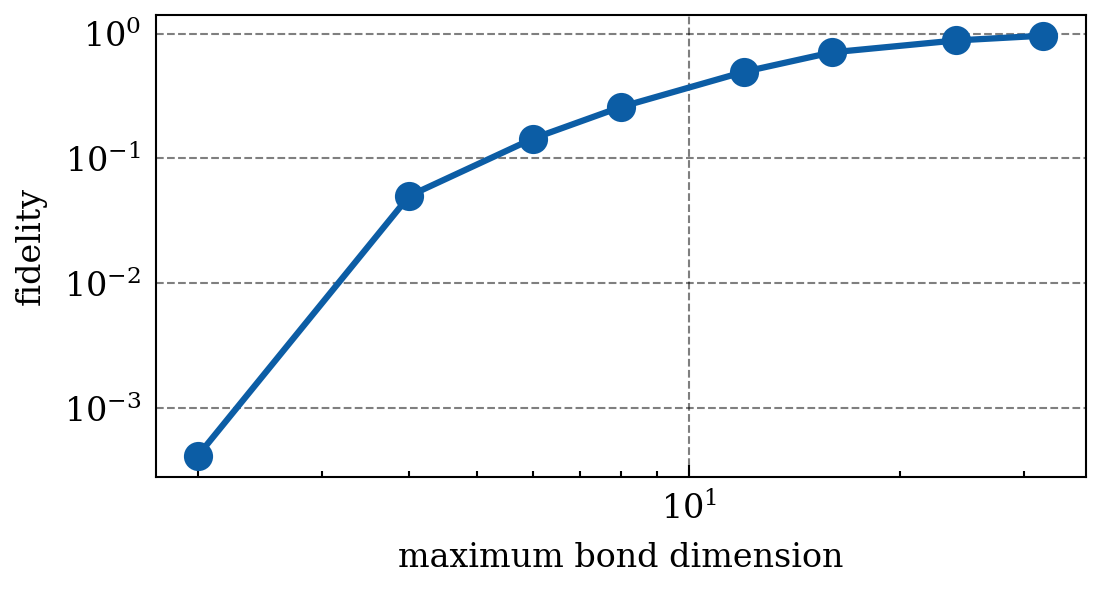

In [17]:
set_style()

plt.figure(figsize=(4,2))

plt.plot(max_dim_opts, fidelities_1, marker='o')
plt.xlabel('maximum bond dimension')
plt.ylabel('fidelity')
plt.yscale('log')
plt.xscale('log')

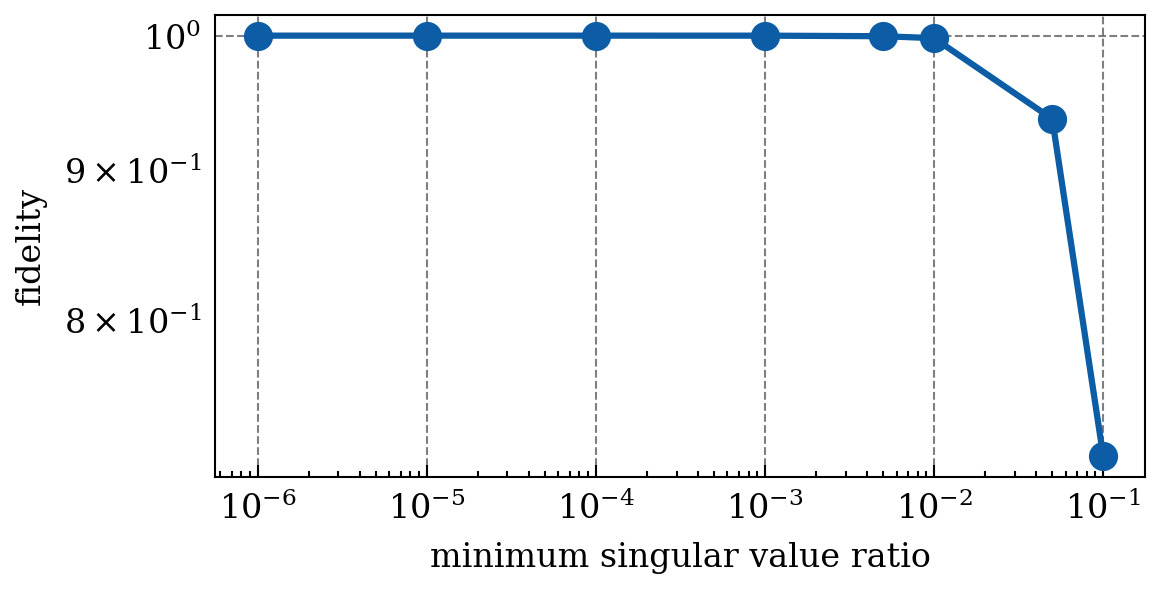

In [19]:
set_style()
plt.figure(figsize=(4,2))

plt.plot(msvr_opts, fidelities_2, marker='o')
plt.xlabel('minimum singular value ratio')
plt.ylabel('fidelity')
plt.yscale('log')
plt.xscale('log')